In [5]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image

print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


PyTorch Version: 2.8.0+cu129
Using device: cuda


In [7]:
# --- 1. Configuration and Data Loading ---

# !!! IMPORTANT: CHANGE THIS TO YOUR DATASET'S PATH !!!
DATA_DIR = r"C:\Users\prath\Desktop\Road_damage_detection\road_damage_dataset"

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15 # Start with 15, can be increased if needed
VALID_SPLIT = 0.2 # 20% of data for validation

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [9]:
# --- 2. Prepare Datasets and Dataloaders ---

# Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(DATA_DIR)

# Split the dataset into training and validation sets
num_data = len(full_dataset)
num_val = int(VALID_SPLIT * num_data)
num_train = num_data - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])

# Apply the respective transforms to the split datasets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes
num_classes = len(class_names)

print(f"Classes found: {class_names}")
print(f"Total images: {num_data}")
print(f"Training images: {dataset_sizes['train']}, Validation images: {dataset_sizes['val']}")


Classes found: ['good', 'poor', 'satisfactory', 'very_poor']
Total images: 2074
Training images: 1660, Validation images: 414


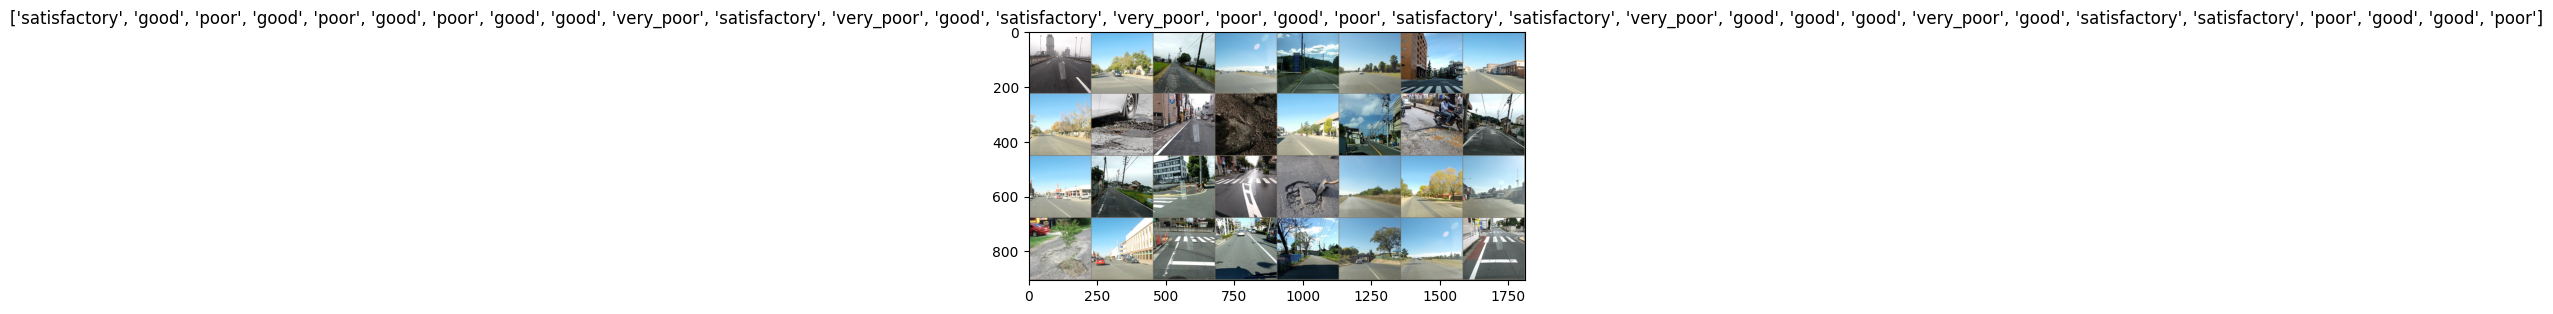

In [10]:
# --- 3. Visualize a few images (Optional) ---

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
imshow(torchvision.utils.make_grid(inputs), title=[class_names[x] for x in classes])

In [11]:
# --- 4. Define the Model (Transfer Learning) ---

# We will use a pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the network parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)
print("Model architecture loaded and modified.")
#print(model) # Uncomment to see model details


Model architecture loaded and modified.


In [12]:
# --- 5. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [13]:
# --- 6. The Training Loop ---
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # Save the best model weights
                torch.save(model.state_dict(), 'road_damage_model.pth')
                print("Best model saved!")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    return model

# Train the model
print("\nStarting training...")
model_ft = train_model(model, criterion, optimizer, num_epochs=EPOCHS)
print("\nTraining finished.")
print("The trained model has been saved as 'road_damage_model.pth'")




Starting training...
Epoch 1/15
----------
train Loss: 0.7795 Acc: 0.7367
val Loss: 0.3427 Acc: 0.9179
Best model saved!
Epoch 2/15
----------
train Loss: 0.3428 Acc: 0.8994
val Loss: 0.2355 Acc: 0.9396
Best model saved!
Epoch 3/15
----------
train Loss: 0.2469 Acc: 0.9277
val Loss: 0.2006 Acc: 0.9469
Best model saved!
Epoch 4/15
----------
train Loss: 0.2187 Acc: 0.9313
val Loss: 0.1789 Acc: 0.9444
Epoch 5/15
----------
train Loss: 0.2043 Acc: 0.9331
val Loss: 0.1662 Acc: 0.9493
Best model saved!
Epoch 6/15
----------
train Loss: 0.1956 Acc: 0.9367
val Loss: 0.1689 Acc: 0.9541
Best model saved!
Epoch 7/15
----------
train Loss: 0.1787 Acc: 0.9434
val Loss: 0.1540 Acc: 0.9517
Epoch 8/15
----------
train Loss: 0.1631 Acc: 0.9476
val Loss: 0.1510 Acc: 0.9541
Epoch 9/15
----------
train Loss: 0.1617 Acc: 0.9458
val Loss: 0.1455 Acc: 0.9517
Epoch 10/15
----------
train Loss: 0.1540 Acc: 0.9506
val Loss: 0.1410 Acc: 0.9493
Epoch 11/15
----------
train Loss: 0.1477 Acc: 0.9542
val Loss: 0.1